In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [2]:
# 필요 라이브러리 모음
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


# 1. 데이터 불러오기 

In [3]:
train_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
test_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"
train_data = pd.read_csv(train_url, sep = '\t')
test_data = pd.read_csv(test_url, sep = '\t')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


# 2. 데이터 전처리
- 결측 데이터 제거
- 중복 데이터 제거

## 2-1. Data Cleansing

In [7]:
def cleanse_sent(sent):
    sent = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sent) # 특수문자 제거
    sent = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', ' ', sent) #remove 한글 자음, 모음
    sent = re.sub(r'\s+', ' ', sent) # remove extra space
    # 연속 느낌표, 물음표 제거
    sent = sent.strip()
    
    return sent

In [8]:
def cleanse_data(data):
    print("total # of rows before cleansing: ", len(data))
    # 결측치 확인 및 제거
    print(f"# of NaN values\n: {data.isnull().sum()}")
    data = data.dropna()
    
    # 'document'열 중복 데이터 확인 및 제거
    print(f"# of duplicated values: {data.duplicated(subset = ['document']).sum()}")
    data = data.drop_duplicates(subset = ['document']) 
    
    # 한글 데이터 전처리
    data['document'] = [cleanse_sent(sent) for sent in data['document']]
    print('total # of rows after cleansing: ', len(data))
    print()
    
    return data    

In [9]:
train_data = cleanse_data(train_data)
test_data = cleanse_data(test_data) 

total # of rows before cleansing:  150000
# of NaN values
: id          0
document    5
label       0
dtype: int64
# of duplicated values: 3813
total # of rows after cleansing:  146182

total # of rows before cleansing:  50000
# of NaN values
: id          0
document    3
label       0
dtype: int64
# of duplicated values: 840
total # of rows after cleansing:  49157



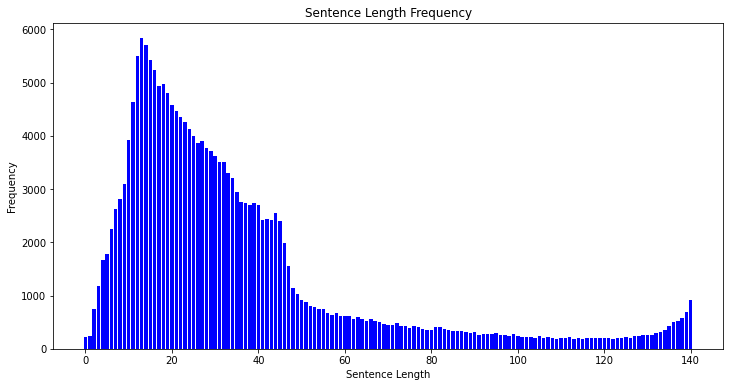

In [10]:
# 문장 길이 분포 확인하기
from collections import Counter

data = pd.concat([train_data, test_data], axis = 0)
data_len = [len(sent) for sent in data['document']]

length_counts = Counter(data_len)
lengths = sorted(length_counts.keys())
frequencies = [length_counts[length] for length in lengths]

plt.figure(figsize = (12, 6))
plt.bar(lengths, frequencies, color = 'blue')
plt.title("Sentence Length Frequency")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

In [11]:
print("min length: ", np.min(data_len))
print("max length: ", np.max(data_len))
print("avg length: ", np.average(data_len))

min length:  0
max length:  140
avg length:  35.15376857667952


In [12]:
# 평균 + 2*표준편차
np.average(data_len) + 2*np.std(data_len)

93.8969886490325

In [13]:
minlen = 5
maxlen = 100

valid_cnt = len([length for length in data_len if minlen <= length <= maxlen])
print(f'''minlen: {minlen}
maxlen: {maxlen}
valid %:{valid_cnt/len(data_len)*100: .2f}% ''')

minlen: 5
maxlen: 100
valid %: 92.16% 


In [14]:
def filter_length(data, minlen, maxlen):
    data['length'] = data['document'].apply(lambda x: len(x))
    data = data[(data['length'] >= minlen) & (data['length'] <= maxlen)]
    data = data.drop(['length'], axis = 1)
    return data

In [15]:
train_filtered = filter_length(train_data, minlen, maxlen)
test_filtered = filter_length(test_data, minlen, maxlen)

In [42]:
np.max([len(sent) for sent in train_filtered['document']])

100

## 2-2 SentencePiece Tokenizer
- train_data 기반으로 SentencePiece Tokenizer 학습시키기
- SentencePiece 성능 확인
- train_data, test_data 적용

In [16]:
def tokenizer(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    
    return tensor, tokenizer

In [17]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_filtered['document']:
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376895 Dec 12 06:50 korean_spm.model
-rw-r--r-- 1 root root 146265 Dec 12 06:50 korean_spm.vocab


In [18]:
# SentencePiece 모델 사용 방법
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1437, 10, 393, 15, 1407, 10, 140, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [19]:
# 특수토큰 확인
s.pad_id()

-1

In [20]:
s.unk_id()

0

In [21]:
s.bos_id()

1

In [22]:
s.eos_id()

2

### Sentence Piece Tokenizer 함수 작성

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [23]:
# SP Tokenizer 함수 작성

def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, value = s.pad_id(), padding='pre')

    return tensor, word_index, index_word

In [24]:
train_corpus = train_filtered['document'].to_list()
train_labels = train_filtered['label'].to_list()
test_corpus = test_filtered['document'].to_list()
test_labels = test_filtered['label'].to_list()

In [25]:
train_tensor, word_index, index_word = sp_tokenize(s, train_corpus)
test_tensor, _, _ = sp_tokenize(s, test_corpus)

In [27]:
# 이름 정리하기...
X_train = np.array(train_tensor)
y_train = np.array(train_labels)
X_test = np.array(test_tensor)
y_test = np.array(test_labels)

In [28]:
X_train_partial = X_train[20000:]
y_train_partial = y_train[20000:]
X_val = X_train[:20000]
y_val = y_train[:20000]

## 2-3 Komoran 형태소 분석기

In [46]:
from konlpy.tag import Komoran
from collections import Counter
komoran = Komoran()

In [47]:
# 성능 테스트
print(train_corpus[0])
print(komoran.morphs(train_corpus[0]))

아 더빙.. 진짜 짜증나네요 목소리
['아', '더빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']


In [82]:
def apply_komoran(train_filtered, test_filterd, num_words = 8000):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한', '하다']
    
    X_train = []
    for sentence in train_filtered['document']:
        temp_X = komoran.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_filtered['document']:
        temp_X = komoran.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value = word_to_index["<PAD>"], padding = "pre")
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value = word_to_index["<PAD>"], padding = "pre")
    
    y_train = np.array(list(train_filtered['label']))
    y_test = np.array(list(test_filtered['label']))
    
    return X_train, y_train, X_test, y_test, word_to_index

In [83]:
X_train_km, y_train_km, X_test_km, y_test_km, word_to_index_km = apply_komoran(train_filtered, test_filtered)

In [84]:
len(X_train_km), len(y_train_km), len(X_test_km), len(y_test_km)

(134795, 134795, 45231, 45231)

In [85]:
X_train_partial_km = X_train_km[20000:]
y_train_partial_km = y_train_km[20000:]
X_val_km = X_train_km[:20000]
y_val_km = y_train_km[:20000]

# 3. 모델 구성 및 Validation set 구성

In [29]:
vocab_size = len(word_index) + 1
embedding_dim = 128
#input_length = X_train.shape[1]

## 3-1. SentencePiece 적용 모델

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model_rnn = tf.keras.Sequential([
    layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_shape = (None, )),
    layers.LSTM(128),
    layers.Dense(32, activation= "relu"),
    layers.Dense(1, activation = "sigmoid")
])

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 73, 128)           1024128   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,159,873
Trainable params: 1,159,873
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model_rnn.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True)

In [38]:
model_rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
epochs = 20
history_rnn = model_rnn.fit(
    X_train_partial, 
    y_train_partial, 
    epochs = epochs, 
    batch_size = 512, 
    validation_data = (X_val, y_val),
    callbacks = [checkpoint])

Epoch 1/20
225/225 [==============================] - 5s 18ms/step - loss: 0.4185 - accuracy: 0.8075 - val_loss: 0.3427 - val_accuracy: 0.8483

Epoch 00001: val_accuracy improved from -inf to 0.84830, saving model to best_model_rnn.keras
Epoch 2/20
225/225 [==============================] - 4s 16ms/step - loss: 0.3210 - accuracy: 0.8608 - val_loss: 0.3386 - val_accuracy: 0.8489

Epoch 00002: val_accuracy improved from 0.84830 to 0.84890, saving model to best_model_rnn.keras
Epoch 3/20
225/225 [==============================] - 4s 16ms/step - loss: 0.2913 - accuracy: 0.8723 - val_loss: 0.3412 - val_accuracy: 0.8493

Epoch 00003: val_accuracy improved from 0.84890 to 0.84935, saving model to best_model_rnn.keras
Epoch 4/20
225/225 [==============================] - 4s 16ms/step - loss: 0.2658 - accuracy: 0.8827 - val_loss: 0.3440 - val_accuracy: 0.8524

Epoch 00004: val_accuracy improved from 0.84935 to 0.85240, saving model to best_model_rnn.keras
Epoch 5/20
225/225 [===================

In [39]:
import matplotlib.pyplot as plt

def draw_history(history, epochs, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, epochs + 1)
    
    plt.figure(figsize = (15, 7))
    
    plt.subplot(121)
    plt.plot(epochs, acc, '--b',  label = 'Training')
    plt.plot(epochs, val_acc, 'b', label = "Valdation")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, '--b',  label = 'Training')
    plt.plot(epochs, val_loss, 'b', label = "Valdation")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.suptitle(f"Training result of model: {model_name}", fontsize = 20)
    
    plt.show()

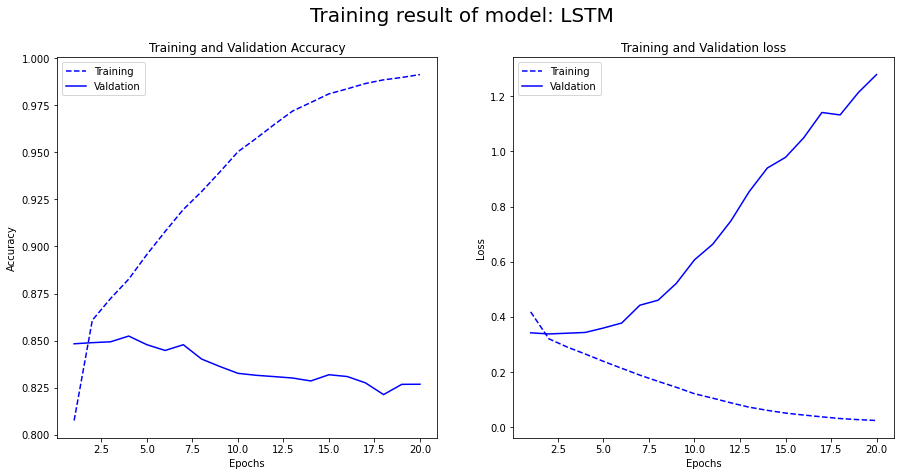

In [40]:
draw_history(history_rnn, epochs, "LSTM")

- 완전 과적합 일어남!!!

In [41]:
from tensorflow.keras.models import load_model

model_rnn = load_model("best_model_rnn.keras")
results_rnn = model_rnn.evaluate(X_test, y_test)

1414/1414 [==============================] - 5s 3ms/step - loss: 0.3548 - accuracy: 0.8489


## 3-2. Komoran 적용 모델 

In [102]:
vocab_size = len(word_to_index_km) + 1
embedding_dim = 128

In [103]:
model_rnn_km = tf.keras.Sequential([
    layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_shape = (None, )),
    layers.LSTM(128),
    layers.Dense(32, activation= "relu"),
    layers.Dense(1, activation = "sigmoid")
])

model_rnn_km.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         1024128   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 1,159,873
Trainable params: 1,159,873
Non-trainable params: 0
_________________________________________________________________


In [104]:
checkpoint = ModelCheckpoint("best_model_rnn_km.keras", monitor = "val_accuracy", verbose = -1, save_best_only = True)
model_rnn_km.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
epochs = 20

In [105]:
history_km = model_rnn_km.fit(
    X_train_partial_km, 
    y_train_partial_km, 
    epochs = epochs, 
    batch_size = 512, 
    validation_data = (X_val_km, y_val_km), 
    callbacks = [checkpoint], 
    verbose= 1)

Epoch 1/20
225/225 [==============================] - 6s 18ms/step - loss: 0.4268 - accuracy: 0.8042 - val_loss: 0.3571 - val_accuracy: 0.8416
Epoch 2/20
225/225 [==============================] - 4s 16ms/step - loss: 0.3342 - accuracy: 0.8548 - val_loss: 0.3455 - val_accuracy: 0.8466
Epoch 3/20
225/225 [==============================] - 4s 17ms/step - loss: 0.3017 - accuracy: 0.8700 - val_loss: 0.3455 - val_accuracy: 0.8518
Epoch 4/20
225/225 [==============================] - 4s 17ms/step - loss: 0.2732 - accuracy: 0.8825 - val_loss: 0.3556 - val_accuracy: 0.8502
Epoch 5/20
225/225 [==============================] - 4s 17ms/step - loss: 0.2485 - accuracy: 0.8949 - val_loss: 0.3690 - val_accuracy: 0.8511
Epoch 6/20
225/225 [==============================] - 4s 17ms/step - loss: 0.2267 - accuracy: 0.9051 - val_loss: 0.3849 - val_accuracy: 0.8462
Epoch 7/20
225/225 [==============================] - 4s 17ms/step - loss: 0.2055 - accuracy: 0.9148 - val_loss: 0.4143 - val_accuracy: 0.8476

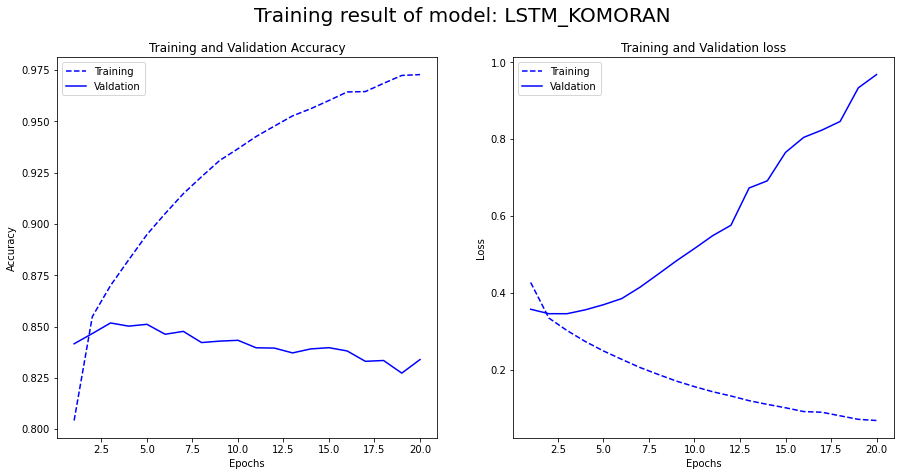

In [106]:
draw_history(history_km, epochs, "LSTM_KOMORAN")

In [107]:
model_rnn_km = load_model("best_model_rnn_km.keras")
results_rnn_km = model_rnn_km.evaluate(X_test, y_test)

1414/1414 [==============================] - 4s 3ms/step - loss: 1.1924 - accuracy: 0.5033


- validation의 accuracy값과 굉장히 차이가 크다...
- 0.50이면 랜덤분류기 아닌가?

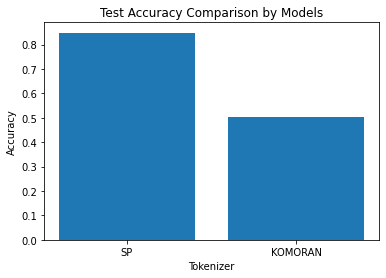

In [108]:
# 성능 비교하기

test_acc = {
    "SP": results_rnn[1],
    "KOMORAN": results_rnn_km[1]
}

plt.bar(test_acc.keys(), test_acc.values())
plt.xlabel("Tokenizer")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison by Models")
plt.show()

# 회고 

- Sentence Piece 사용한 모델에 비해 KOMORAN 사용 모델 성능(Accuracy)가 30% 이상 낮음
- KOMORAN 모델은 학습 데이터에는 과적합 되었지만 일반화 성능이 SP에 비해 낮은 것 같음
- KOMORAN OOV 처리 성능이 sentence piece에 비해 훨씬 약한 것인가?

